# Mesa Testing

In this notebook we test and develop the needed classes that are going to be used in the eventual P2P-energy trading simulation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math

import mesa
from datetime import datetime
from dateutil.relativedelta import relativedelta

from utils import generate_household_dataframe

In [2]:
profile_ratios = {
    'vroege_vogel': 0.2,
    'avondmens': 0.3,
    'standaard': 0.4,
    'zuinig': 0.1
}

df = generate_household_dataframe(n_days=10, n_households=10, profile_ratios=profile_ratios)
print(df['profiel'].value_counts())

profiel
standaard       40
avondmens       30
vroege_vogel    20
zuinig          10
Name: count, dtype: int64


In [3]:
consumption_df = generate_household_dataframe(n_days=365, n_households=30)
production_df = pd.read_csv("data/solar_strength.csv", index_col="DATE")

In [4]:
display(consumption_df.head())
display(production_df.head())

,household,profiel,totaal_kWh,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
datum,,,,,,,,,,,,,,,,,,,,,
01-01-2024,household_1,vroege_vogel,10.596479,0.091436,0.088158,0.084188,0.089518,0.092917,0.099406,0.552083,...,0.484777,0.519271,0.517414,0.506260,0.520912,0.477224,0.602126,0.477485,0.599714,0.508931
02-01-2024,household_1,vroege_vogel,11.014849,0.091758,0.087155,0.097220,0.088774,0.083880,0.076304,0.676700,...,0.488282,0.575515,0.545965,0.469049,0.578400,0.525793,0.566214,0.548532,0.553335,0.483291
03-01-2024,household_1,vroege_vogel,10.989124,0.100781,0.083964,0.086444,0.090208,0.093115,0.094368,0.674999,...,0.629464,0.545446,0.567632,0.559345,0.519634,0.442904,0.568425,0.572147,0.534540,0.518336
04-01-2024,household_1,vroege_vogel,10.870500,0.087067,0.084346,0.083844,0.089058,0.081394,0.092079,0.657385,...,0.543910,0.576692,0.567478,0.513470,0.595122,0.550796,0.507041,0.560344,0.541711,0.415743
05-01-2024,household_1,vroege_vogel,11.099923,0.091838,0.089873,0.077219,0.071144,0.084870,0.099625,0.677734,...,0.574889,0.592097,0.505003,0.584208,0.605226,0.561661,0.505039,0.564962,0.507005,0.660549


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DATE,,,,,,,,,,,,,,,,,,,,,
01-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,4.50,36.17,...,97.17,8.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,13.50,46.33,...,8.33,1.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,9.67,44.17,...,12.00,5.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.67,53.17,...,67.67,18.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05-01-2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33,8.33,31.50,...,27.33,7.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
class Household_2(mesa.Agent):
    """
    The Household Agent is the basic Agent template used during our sumulations.
    It is able to withdraw information about its own consumption and production details
    from our synthetically generated data. Next to that, it holds the capacity to trade
    energy with other Agents in the simulation.

    Methods:
    ----------
    trade_energy(self)
        A method that functions as the main use for our Agents. Using this method makes
        the agent look up the needed consumption and production data, along with trading
        energy with other Agents.

    _calculate_energy(self)
        A method used to calculate the energy surplus or deficit, using its corresponding
        consumption and solar strength values. The producyion is calculated as follows:
            Production = solar_strength * (amount_of_solar_panels * avg_area_per_solar_panel)
    
    _lookup_data_for_agent(self, data)
        A method that uses the dataframe in order to find the needed consumption and
        solar strength value.
    
    _trading(self)
        A method holding the trading methods and logic for when not to start trading.
    
    _look_for_trades(self)
        A method that looks through the Agents for potential buyers and sellers.

    _exchange_energy(self)
        A method that handles the logic to exchange energy until either the buyer has
        enough or until the seller no longer has a surplus.
    """

    def __init__(self, model):
        """
        Initializes a household agent with a random number of solar panels and several other
        attributes needed to run the code without errors.
        """
        super().__init__(model)

        self.solar_panel_area = round(self.solar_panels_at_position(Gini=0.1, mean_panels=8, n=30, i=self.unique_id), 1)
        self.supply = 1
        self.demand = 1

        self.remaining_energy = 0
        self.consumed = 0
        self.produced = 0
        self.trade_amount = 0

        self.energy_price = self.model.energy_price
        self.grid_price = 0.1710
        print(self.unique_id, "Solar energy:", self.solar_panel_area)
        # print(f"[INIT] Household initialized with {self.amount_of_solarpanels} solar panels.")
        # print(f"[INIT] Consumption: {self.consumption_data} | Production: {self.production_data}")

    
    def solar_panels_distribution(self, Gini, mean_panels, n):
        k = Gini / (1 - Gini)
    
        # Bereken ruwe verdeling
        raw = [(2 * (i + 0.5) / n) ** k for i in range(n)]
        
        # Normaliseer zodat het totaal gelijk blijft aan mean_panels * n
        total_raw = sum(raw)
        factor = (mean_panels * n) / total_raw
        normalized = [x * factor for x in raw]
    
        return normalized

    def solar_panels_at_position(self, Gini, mean_panels, n, i):
        return self.solar_panels_distribution(Gini, mean_panels, n)[i - 1]
        
    def trade_energy(self):
        # print(f"\n[TRADE] Time: Day {self.model.day_str}, Hour {self.model.hour}")
        self._calculate_energy()
        self._trading()

        if self.remaining_energy > 0:
            self.model.hourly_supply[self.model.hour] += self.remaining_energy
        else:
            self.model.hourly_demand[self.model.hour] += abs(self.remaining_energy)

    def _calculate_energy(self):
        self.consumed = self._lookup_data_for_agent(self.model.consumption_data)
        self.solar_strength = self.model.production_data.loc[self.model.day_str, f"{self.model.hour}"]

        # Wh = (W/m2 * m2) * h
        # kWh = Wh / 1000
        self.produced = (self.solar_strength * self.solar_panel_area * 0.2) / 1000

        self.remaining_energy = self.produced - self.consumed
        # print(f"[CALC] Consumed: {self.consumed}, Produced: {self.produced}, Remaining: {self.remaining_energy}")

    def _lookup_data_for_agent(self, data):
        household_id = f"household_{self.unique_id}"
        day_data = data.loc[self.model.day_str]
        lookup_data = day_data[day_data["household"] == household_id][f"{self.model.hour}"].values[0]
        return lookup_data

    def _trading(self):
        self._look_for_trades()
        if not self.buyers:
            # print("[TRADE] No buyers found.")
            return

        if self.remaining_energy <= 0:
            # print("[TRADE] No surplus energy to trade.")
            return

        self._exchange_energy(self.buyers)

    def _look_for_trades(self):
        self.buyers = [
            agent for agent in self.model.agents
            if agent.remaining_energy < agent.consumed
        ]
        self.sellers = [
            agent for agent in self.model.agents
            if agent.remaining_energy > agent.consumed
        ]
        # print(f"[MARKET] Buyers: {len(self.buyers)} | Sellers: {len(self.sellers)}")

    def _exchange_energy(self, buyers):
        for buyer in buyers:
            potential_trade = buyer.consumed - buyer.remaining_energy
            if potential_trade <= 0:
                continue

            trade_amount = min(self.remaining_energy, potential_trade)

            if trade_amount <= 0:
                continue

            self.remaining_energy -= trade_amount
            buyer.remaining_energy += trade_amount

            # print(f"[EXCHANGE] Traded {trade_amount} units to Buyer (ID: {buyer.unique_id})")
            # print(f"[TRADER] Remaining energy: {self.remaining_energy}W")

            if self.remaining_energy <= 0:
                # print("[TRADE] No more energy to trade.")
                break


In [9]:
class NewGrid(mesa.Model):
    def __init__(self, n, consumption_data, production_data, solar_panel_odds=0.35, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.solar_panel_odds = solar_panel_odds

        self.consumption_data = consumption_data
        self.production_data = production_data

        self.datetime = datetime(2024, 1, 1)
        self.hour = 0
        self.day_str = self.datetime.strftime("%d-%m-%Y")

        self.hourly_demand = [0] * 24
        self.hourly_supply = [0] * 24
        self.energy_price = 0.16
        self.grid_price = 0.171

        self.smoothing = 0.3
        self.elasticity = 0.4
        self.min_price = 0.10

        self.avg_demand = 1
        self.avg_supply = 1

        self.daily_energy_prices = []  # Store energy price per day
        self.hourly_surplus_deficit = []  # Store surplus/deficit per hour for households
        self.total_consumption_per_hour = []  # Total energy consumption per hour
        self.total_production_per_hour = []  # Total energy production per hour
        self.household_solar_panels = []  # Store number of solar panels per household
        self.pressure_price_data = []  # Store pressure vs price data for plotting
        self.trade_price_data = []  # Store price vs surplus/deficit for trading
        self.total_demand_history = []  # List to hold cumulative demand data
        self.total_supply_history = []  # List to hold cumulative supply data

        Household_2.create_agents(model=self, n=n)

    def _time_skip(self):
        if self.hour != 23:
            self.hour += 1
        else:
            self.datetime += relativedelta(days=1)
            self.day_str = self.datetime.strftime("%d-%m-%Y")
            self.hour = 0
        
        if self.hour == 0:
            self._update_energy_price()
            self.collect_daily_data()

        # Collect data for the day
        self.collect_hourly_data()

    def _update_energy_price(self):
        target_price = self._calculate_target_price()

        # --- Smoothed Transition ---
        self.energy_price = (1 - self.smoothing) * self.energy_price + self.smoothing * target_price

        # Output energy price for the day
        print(f"[DAILY PRICE UPDATE :: {self.day_str}]: "
            f"Price={self.energy_price:.4f}"
            # f"Supply={self.hourly_supply}\n"
            # f"Demand={self.hourly_demand}"
            )

    def _calculate_target_price(self):
        min_price = 0.10
        max_price = self.grid_price
        
        demand_list = self.hourly_demand
        supply_list = self.hourly_supply

        # Avoid zero division
        valid_hours = [i for i in range(24) if supply_list[i] > 0]
        if not valid_hours:
            return self.grid_price  # fallback

        hourly_pressures = [
        demand_list[i] / supply_list[i] for i in valid_hours
        ]
        
        # Calculate the average pressure across valid hours
        pressure = np.mean(hourly_pressures)

        # If demand exceeds supply, increase the price, but with diminishing returns
        if pressure > 1:
            # The more extreme the imbalance, the stronger the price increase
            price_increase = (pressure - 1) * self.elasticity
            new_price = self.energy_price * (1 + price_increase)
        else:
            # If supply exceeds demand, decrease the price but not too sharply
            price_decrease = (1 - pressure) * self.elasticity
            new_price = self.energy_price * (1 - price_decrease)

        # Apply bounds to ensure the price stays within the limits
        new_price = max(min_price, min(new_price, max_price))

        return new_price

    def collect_daily_data(self):
        # Collect the daily totals (once per day)
        self.total_demand_history.append(sum(self.hourly_demand))
        self.total_supply_history.append(sum(self.hourly_supply))

        self.daily_energy_prices.append(self.energy_price)

        # Reset hourly data for the next day
        self.hourly_demand = [0] * 24
        self.hourly_supply = [0] * 24

    def collect_hourly_data(self):
        # Collect hourly data that updates every hour
        self.total_consumption_per_hour.append(sum(agent.consumed for agent in self.agents))
        self.total_production_per_hour.append(sum(agent.produced for agent in self.agents))

        surplus_deficit = [agent.remaining_energy for agent in self.agents]
        self.hourly_surplus_deficit.append(surplus_deficit)

        # Collect household solar panel distribution
        solar_panels = [agent.solar_panel_area for agent in self.agents]
        self.household_solar_panels.append(solar_panels)

        # Collect pressure vs price data
        pressures = [self.avg_demand / self.avg_supply]
        self.pressure_price_data.extend(zip(pressures, [self.energy_price] * len(pressures)))

        # Collect price vs surplus/deficit data for trading
        for agent in self.agents:
            self.trade_price_data.append((agent.remaining_energy, agent.energy_price))

    def step(self):
        self.agents.shuffle_do("trade_energy")
        for agent in self.agents:
            print(f"""
            Statistics for Agent {agent}:
            Current day: {self.day_str}
            Current energy price: {agent.energy_price}
            Current remaining energy: {agent.remaining_energy}
            Last consumed: {agent.consumed}
            Last produced: {agent.produced}
            Total agent amount: {self.num_agents}
            """)

    def long_step(self, n):
        for _ in range(0, n):
            self.agents.shuffle_do("trade_energy")

            self._time_skip()

In [10]:
 sim.step()

1 Solar energy: 5.6
2 Solar energy: 6.4
3 Solar energy: 6.7
4 Solar energy: 7.0
5 Solar energy: 7.2
6 Solar energy: 7.4
7 Solar energy: 7.5
8 Solar energy: 7.6
9 Solar energy: 7.7
10 Solar energy: 7.8
11 Solar energy: 7.9
12 Solar energy: 8.0
13 Solar energy: 8.1
14 Solar energy: 8.1
15 Solar energy: 8.2
16 Solar energy: 8.3
17 Solar energy: 8.3
18 Solar energy: 8.4
19 Solar energy: 8.4
20 Solar energy: 8.5
21 Solar energy: 8.5
22 Solar energy: 8.6
23 Solar energy: 8.6
24 Solar energy: 8.6
25 Solar energy: 8.7
26 Solar energy: 8.7
27 Solar energy: 8.8
28 Solar energy: 8.8
29 Solar energy: 8.8
30 Solar energy: 8.9

            Statistics for Agent <__main__.Household_2 object at 0x000001C44611FBD0>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: -0.09143581724861423
            Last consumed: 0.09143581724861423
            Last produced: 0.0
            Total agent amount: 30
            

            Statistics for Agen

In [11]:
sim.long_step(365*24)

[DAILY PRICE UPDATE :: 02-01-2024]: Price=0.1633
[DAILY PRICE UPDATE :: 03-01-2024]: Price=0.1656
[DAILY PRICE UPDATE :: 04-01-2024]: Price=0.1672
[DAILY PRICE UPDATE :: 05-01-2024]: Price=0.1684
[DAILY PRICE UPDATE :: 06-01-2024]: Price=0.1692
[DAILY PRICE UPDATE :: 07-01-2024]: Price=0.1697
[DAILY PRICE UPDATE :: 08-01-2024]: Price=0.1701
[DAILY PRICE UPDATE :: 09-01-2024]: Price=0.1704
[DAILY PRICE UPDATE :: 10-01-2024]: Price=0.1706
[DAILY PRICE UPDATE :: 11-01-2024]: Price=0.1707
[DAILY PRICE UPDATE :: 12-01-2024]: Price=0.1708
[DAILY PRICE UPDATE :: 13-01-2024]: Price=0.1708
[DAILY PRICE UPDATE :: 14-01-2024]: Price=0.1709
[DAILY PRICE UPDATE :: 15-01-2024]: Price=0.1709
[DAILY PRICE UPDATE :: 16-01-2024]: Price=0.1709
[DAILY PRICE UPDATE :: 17-01-2024]: Price=0.1710
[DAILY PRICE UPDATE :: 18-01-2024]: Price=0.1710
[DAILY PRICE UPDATE :: 19-01-2024]: Price=0.1710
[DAILY PRICE UPDATE :: 20-01-2024]: Price=0.1710
[DAILY PRICE UPDATE :: 21-01-2024]: Price=0.1710
[DAILY PRICE UPDATE 

## Visualisation Ideas

- Energy demand vs supply over time
- Energy price fluctuations over time
- Individual household average energy production en consumption graph (voor tim en jasper)
- Trade Network graph
- Surplus/Defecit energy distribution across households
- Total energy production/consumption per time given (hour, day, week, month)
- Household solar panel distribution
- Trading Price dynamics (price vs surplus/deficit)
- Pressure vs Price
- Agent consumption and production over timespan (tim en jasper)

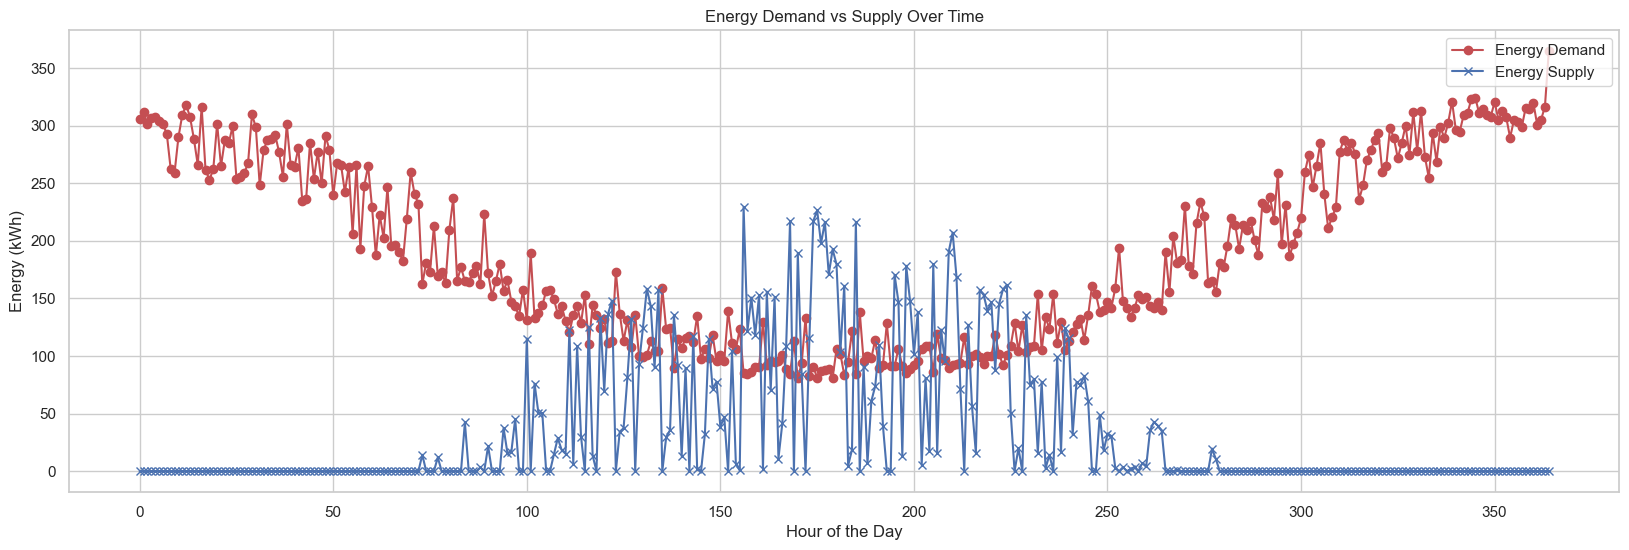

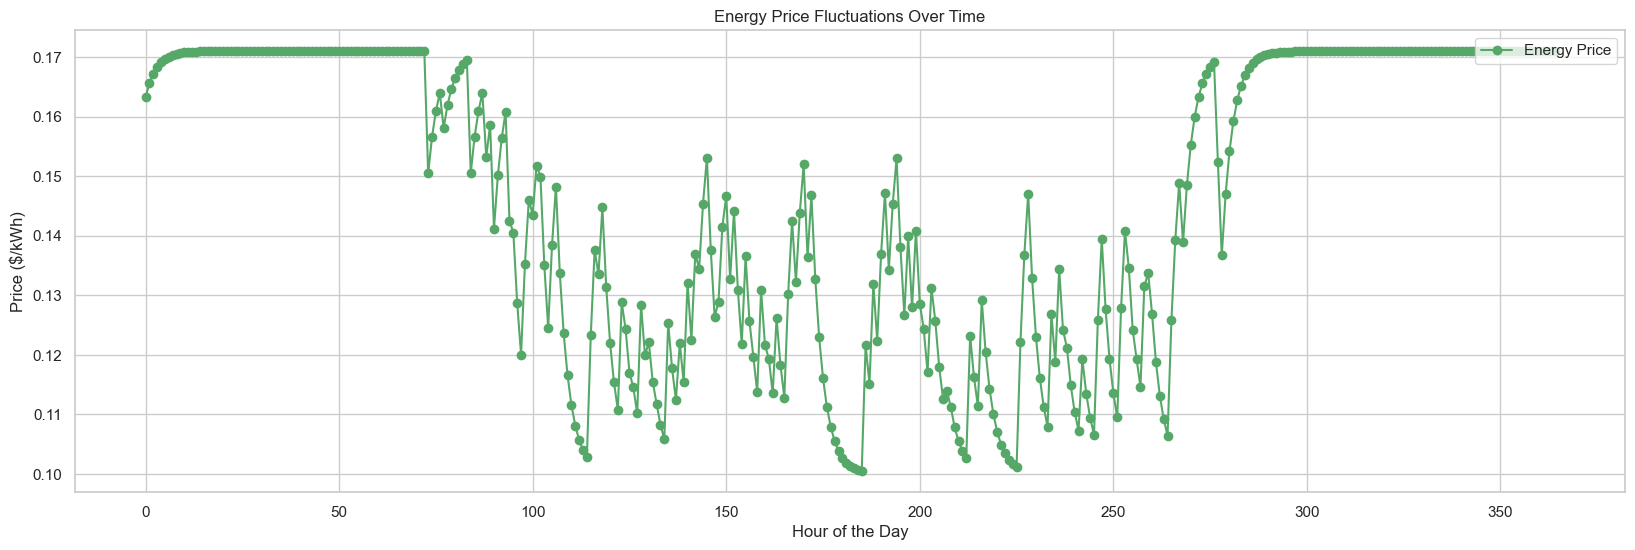

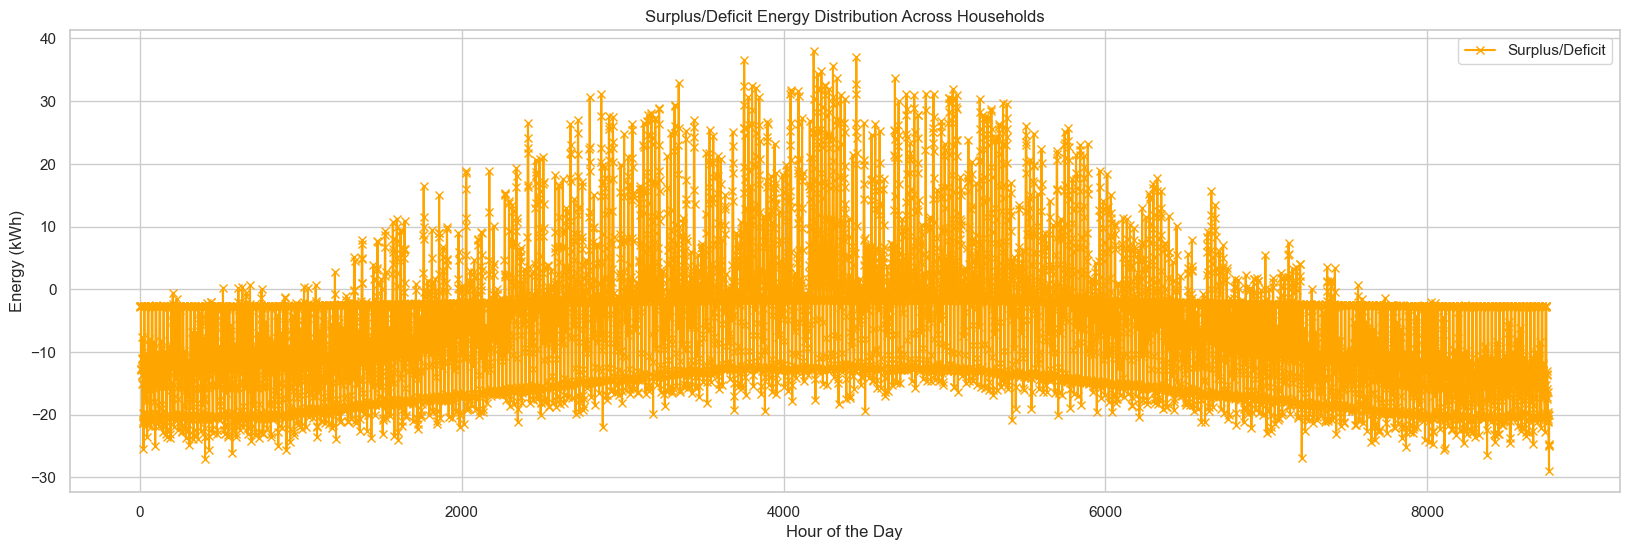

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Ensure the use of a nice style for the plots
sns.set_theme(style="whitegrid")

# ----- 1. Energy Demand vs Supply Over Time -----
def plot_energy_demand_vs_supply(model):
    # Aggregating data for demand and supply
    hours = range(len(model.total_demand_history))

    plt.figure(figsize=(20, 6))
    plt.plot(hours, model.total_demand_history, label='Energy Demand', color='r', marker='o')
    plt.plot(hours, model.total_supply_history, label='Energy Supply', color='b', marker='x')

    plt.title('Energy Demand vs Supply Over Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Energy (kWh)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 2. Energy Price Fluctuations Over Time -----
def plot_energy_price_fluctuations(model):
    # Plotting energy price over time
    hours = range(len(model.daily_energy_prices))

    plt.figure(figsize=(20, 6))
    plt.plot(hours, model.daily_energy_prices, label='Energy Price', color='g', marker='o')

    plt.title('Energy Price Fluctuations Over Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Price ($/kWh)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 4. Surplus/Deficit Energy Distribution Across Households -----
def plot_surplus_deficit_distribution(model):
    # Collect surplus/deficit data for households
    hours = range(len(model.hourly_surplus_deficit))
    surplus_deficit = [sum(hour_data) for hour_data in model.hourly_surplus_deficit]

    plt.figure(figsize=(20, 6))
    plt.plot(hours, surplus_deficit, label='Surplus/Deficit', color='orange', marker='x')

    plt.title('Surplus/Deficit Energy Distribution Across Households')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Energy (kWh)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 7. Trading Price Dynamics (Price vs Surplus/Deficit) -----
def plot_trading_price_dynamics(model):
    # Plot trading price vs surplus/deficit
    trading_data = model.trade_price_data
    surplus_deficit, prices = zip(*trading_data)

    plt.figure(figsize=(20, 6))
    plt.scatter(surplus_deficit, prices, color='b', label='Price vs Surplus/Deficit', alpha=0.7)

    plt.title('Trading Price Dyn amics (Price vs Surplus/Deficit)')
    plt.xlabel('Surplus/Deficit (kWh)')
    plt.ylabel('Price ($/kWh)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# ----- 8. Pressure vs Price -----
def plot_pressure_vs_price(model):
    # Plot pressure vs price dynamics
    pressures, prices = zip(*model.pressure_price_data)

    plt.figure(figsize=(20, 6))
    plt.plot(pressures, prices, label='Pressure vs Price', color='g', marker='o')

    plt.title('Pressure vs Price')
    plt.xlabel('Market Pressure (Demand/Supply)')
    plt.ylabel('Price ($/kWh)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# --- Usage of the functions ---
# Assuming you have an instance of the model `model`
plot_energy_demand_vs_supply(sim)
plot_energy_price_fluctuations(sim)
plot_surplus_deficit_distribution(sim)
# plot_trading_price_dynamics(sim)
# plot_pressure_vs_price(sim)